# HSCT survival clustered linear regression

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_curve, precision_recall_curve

training_features_df_file='./data/processed/02.1-scaled_encoded_training_features_df.parquet'
training_labels_df_file='./data/processed/02.1-scaled_encoded_training_labels_df.parquet'

model_file='./models/03.1-linear_regression.pkl'

## 1. Load data

Features: (28800, 178)
Labels: (28800, 2)


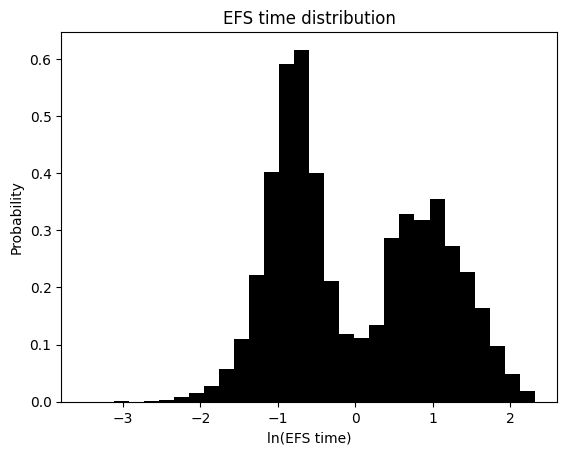

In [2]:
# Load the datasets
features_df=pd.read_parquet(training_features_df_file)
labels_df=pd.read_parquet(training_labels_df_file)

# Remove id column from training features
features_df.drop('ID', axis=1, inplace=True)

print(f'Features: {features_df.shape}')
print(f'Labels: {labels_df.shape}')

plt.title('EFS time distribution')
plt.hist(labels_df['efs_time'], density=True, bins=30, color='black')
plt.xlabel('ln(EFS time)')
plt.ylabel('Probability')
plt.show()

## 2. Make naive linear regression predictions

In [3]:
# Load the baseline linear regression model
with open(model_file, 'rb') as input_file:
    regression_model=pickle.load(input_file)

# Make predictions for the whole training set
predictions=regression_model.predict(features_df)

predictions_df=pd.DataFrame.from_dict({
    'EFS time': labels_df['efs_time'],
    'Predicted EFS time': predictions
})

## 3. Cluster predictions

In [4]:
kmeans=KMeans(n_clusters=2, random_state=0, n_init="auto").fit(predictions_df)
predictions_df['Cluster']=kmeans.labels_

## 4. Plot

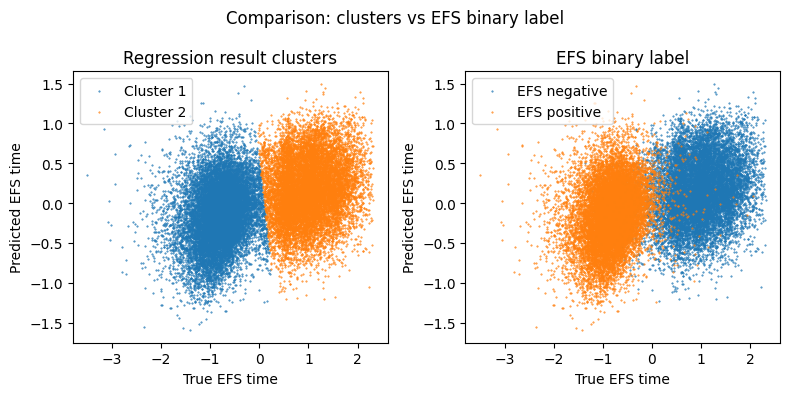

In [5]:
predictions_df['Predicted EFS time']=predictions
predictions_df['EFS time']=labels_df['efs_time']
predictions_df['EFS']=labels_df['efs']

cluster_one=predictions_df[predictions_df['Cluster'] == 0]
cluster_two=predictions_df[predictions_df['Cluster'] == 1]

efs_neg=predictions_df[predictions_df['EFS'] == 0]
efs_pos=predictions_df[predictions_df['EFS'] == 1]

# Plot the results
fig, axs=plt.subplots(1,2, figsize=(8,4))
axs=axs.flatten()

fig.suptitle('Comparison: clusters vs EFS binary label')

axs[0].set_title('Regression result clusters')
axs[0].scatter(cluster_one['EFS time'], cluster_one['Predicted EFS time'], s=0.2, label='Cluster 1')
axs[0].scatter(cluster_two['EFS time'], cluster_two['Predicted EFS time'], s=0.2, label='Cluster 2')
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')
axs[0].legend(loc='best')

axs[1].set_title('EFS binary label')
axs[1].scatter(efs_neg['EFS time'], efs_neg['Predicted EFS time'], s=0.2, label='EFS negative')
axs[1].scatter(efs_pos['EFS time'], efs_pos['Predicted EFS time'], s=0.2, label='EFS positive')
axs[1].set_xlabel('True EFS time')
axs[1].set_ylabel('Predicted EFS time')
axs[1].legend(loc='best')

plt.tight_layout()
plt.show()

## 5. Learn EFS binary

In [6]:
classifier=LogisticRegression(max_iter=10000, random_state=315)
result=classifier.fit(features_df, labels_df['efs'])
predictions_df['Predicted EFS probability']=classifier.predict(features_df)

### 5.1. Distribution of predicted EFS probabilities

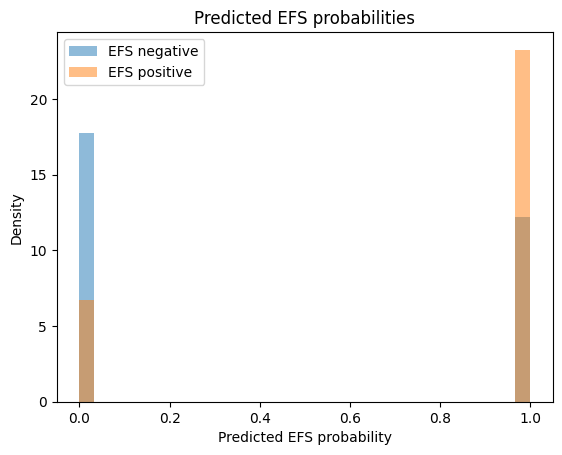

In [7]:
plt.title('Predicted EFS probabilities')
plt.hist(predictions_df['Predicted EFS probability'][predictions_df['EFS'] == 0], bins=30, density=True, alpha=0.5, label='EFS negative')
plt.hist(predictions_df['Predicted EFS probability'][predictions_df['EFS'] == 1], bins=30, density=True, alpha=0.5, label='EFS positive')
plt.xlabel('Predicted EFS probability')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

### 5.2. Receiver-operator characteristic and precision-recall curves

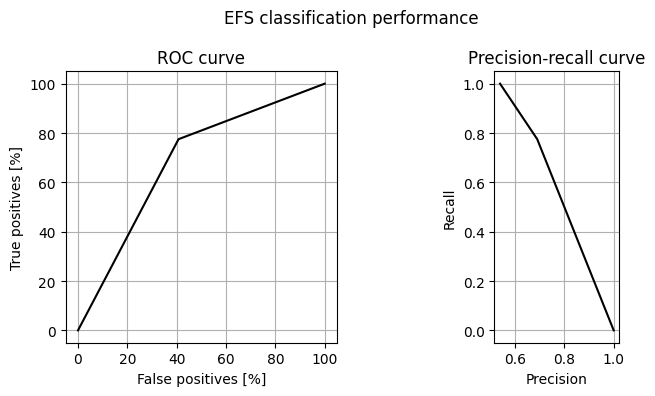

In [8]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('EFS classification performance', size='large')

# Plot ROC curve
fp, tp, _ = roc_curve(predictions_df['EFS'], predictions_df['Predicted EFS probability'])
axs[0].set_title('ROC curve')
axs[0].plot(100*fp, 100*tp, color='black')
axs[0].set_xlabel('False positives [%]')
axs[0].set_ylabel('True positives [%]')
axs[0].grid(True)
axs[0].set_aspect('equal')

# Plot PR curve
precision, recall, _ = precision_recall_curve(predictions_df['EFS'], predictions_df['Predicted EFS probability'])
axs[1].set_title('Precision-recall curve')
axs[1].plot(precision, recall, color='black')
axs[1].set_xlabel('Precision')
axs[1].set_ylabel('Recall')
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

Precision: 0.690
Recall: 0.775



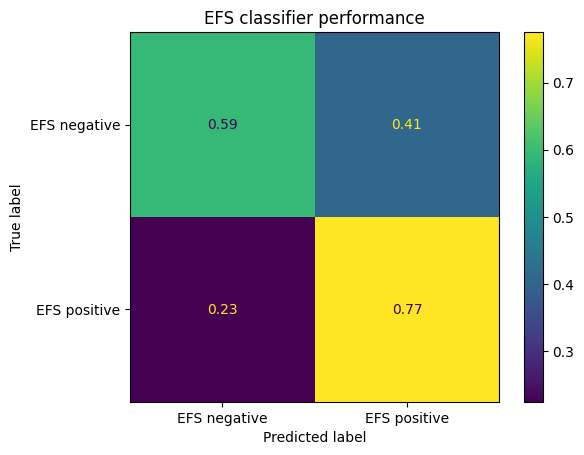

In [9]:
# Set threshold and call incidents
threshold=0.5
calls=np.where(predictions_df['Predicted EFS probability'] > threshold, 1, 0)
features_df['Learned cluster']=calls
labels_df['Learned cluster']=calls

# Calculate precision and recall
precision=precision_score(predictions_df['EFS'], calls)
recall=recall_score(predictions_df['EFS'], calls)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}\n')

# Plot the confusion matrix
cm=confusion_matrix(predictions_df['EFS'], calls, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['EFS negative', 'EFS positive'])
_=cm_disp.plot()
plt.title('EFS classifier performance')
plt.show()

## 6. Regression in clusters

### 6.1. Split data by learned cluster assignment

In [10]:
clustered_features={
    'cluster_one': features_df[features_df['Learned cluster'] == 0],
    'cluster_two': features_df[features_df['Learned cluster'] == 1]
}

clustered_labels={
    'cluster_one': labels_df[labels_df['Learned cluster'] == 0],
    'cluster_two': labels_df[labels_df['Learned cluster'] == 1]
}

### 6.2. Cluster regression

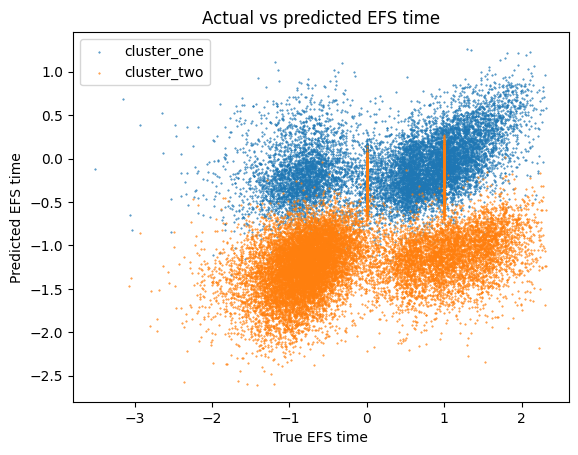

In [11]:
models={
    'cluster_one': LinearRegression(),
    'cluster_two': LinearRegression()
}

for cluster in clustered_features.keys():
    models[cluster].fit(clustered_features[cluster], clustered_labels[cluster])

predictions={}

for cluster in clustered_features.keys():
    cluster_predictions=models[cluster].predict(clustered_features[cluster])
    predictions[cluster]=cluster_predictions - np.mean(cluster_predictions) * 2


plt.title('Actual vs predicted EFS time')

for cluster in clustered_features.keys():
    plt.scatter(clustered_labels[cluster], predictions[cluster], s=0.2, label=cluster)

plt.xlabel('True EFS time')
plt.ylabel('Predicted EFS time')
plt.legend(loc='best')
plt.show()